In [1]:
%load_ext autoreload
%autoreload 2

from cnn import CNN
from dyn_cnn import DynCNN
from util import Util
from patch import Patch
from fixer import Fixer
from uglify import Uglify

import cPickle as pickle
import os
import mahotas as mh
import numpy as np
import time

import mlproof as mlp


from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled, CuDNN 4007)
/home/d/nolearn/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
tifffile.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tifffile.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tifffile.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
with open('/home/d/nets/MergeNet_cylinder1_larger_border_overlap_usevars/net.p', 'rb') as f:
    cnn = pickle.load(f)

In [3]:
with open('/home/d/dojo_xp/data/bigM_cylinder_250_300.p', 'rb') as f:
    m_s = pickle.load(f)

In [4]:
# load data as volume
volume = []
volume_prob = []
volume_segmentation = []
volume_groundtruth = []
for z in range(250, 300):
    image, prob, mask, gold, rhoana = mlp.Util.read_section('/home/d/data/cylinder/', z)
    
    volume.append(image)
    volume_prob.append(prob)
    volume_segmentation.append(rhoana)
    volume_groundtruth.append(gold)

Loading z00000250.png
Loading z00000251.png
Loading z00000252.png
Loading z00000253.png
Loading z00000254.png
Loading z00000255.png
Loading z00000256.png
Loading z00000257.png
Loading z00000258.png
Loading z00000259.png
Loading z00000260.png
Loading z00000261.png
Loading z00000262.png
Loading z00000263.png
Loading z00000264.png
Loading z00000265.png
Loading z00000266.png
Loading z00000267.png
Loading z00000268.png
Loading z00000269.png
Loading z00000270.png
Loading z00000271.png
Loading z00000272.png
Loading z00000273.png
Loading z00000274.png
Loading z00000275.png
Loading z00000276.png
Loading z00000277.png
Loading z00000278.png
Loading z00000279.png
Loading z00000280.png
Loading z00000281.png
Loading z00000282.png
Loading z00000283.png
Loading z00000284.png
Loading z00000285.png
Loading z00000286.png
Loading z00000287.png
Loading z00000288.png
Loading z00000289.png
Loading z00000290.png
Loading z00000291.png
Loading z00000292.png
Loading z00000293.png
Loading z00000294.png
Loading z0

In [7]:
new_m_s, out_volume, fixes, vi_s30mins = Fixer.splits_global_from_M(cnn, m_s, 
                                                 volume, 
                                                 volume_prob, 
                                                 volume_segmentation, 
                                                 volume_groundtruth,
                                                 hours=-1)

518400
30 minutes done bigM_max= 1.0
30 minutes done bigM_max= 1.0
30 minutes done bigM_max= 1.0
30 minutes done bigM_max= 1.0
30 minutes done bigM_max= 1.0
30 minutes done bigM_max= 1.0
30 minutes done bigM_max= 1.0
30 minutes done bigM_max= 1.0
30 minutes done bigM_max= 1.0
30 minutes done bigM_max= 1.0
30 minutes done bigM_max= 1.0
30 minutes done bigM_max= 1.0
60 minutes done bigM_max= 0.999999761581
60 minutes done bigM_max= 0.999999761581
60 minutes done bigM_max= 0.999999761581
60 minutes done bigM_max= 0.999999761581
60 minutes done bigM_max= 0.999999761581
60 minutes done bigM_max= 0.999999761581
60 minutes done bigM_max= 0.999999761581
60 minutes done bigM_max= 0.999999761581
60 minutes done bigM_max= 0.999999761581
60 minutes done bigM_max= 0.999999761581
60 minutes done bigM_max= 0.999999761581
60 minutes done bigM_max= 0.999999761581
90 minutes done bigM_max= 0.999997496605
90 minutes done bigM_max= 0.999997496605
90 minutes done bigM_max= 0.999997496605
90 minutes done bi

In [12]:
len(fixes)

7535

In [14]:
from collections import Counter
good_fixes_per_minute = []
bad_fixes_per_minute = []
good_encoded_fixes = []
bad_encoded_fixes = []
for f in range(len(fixes)):
    if fixes[f] == 'Good':
        good_encoded_fixes.append(1)
        bad_encoded_fixes.append(-1)
    elif fixes[f] == 'Bad':
        good_encoded_fixes.append(-1)
        bad_encoded_fixes.append(1)
    
for f in range(0,len(fixes),12):
    counts = Counter(fixes[f:f+12])
    good_counts = counts['Good']
    bad_counts = counts['Bad']
    good_fixes_per_minute.append(good_counts)
    bad_fixes_per_minute.append(bad_counts)

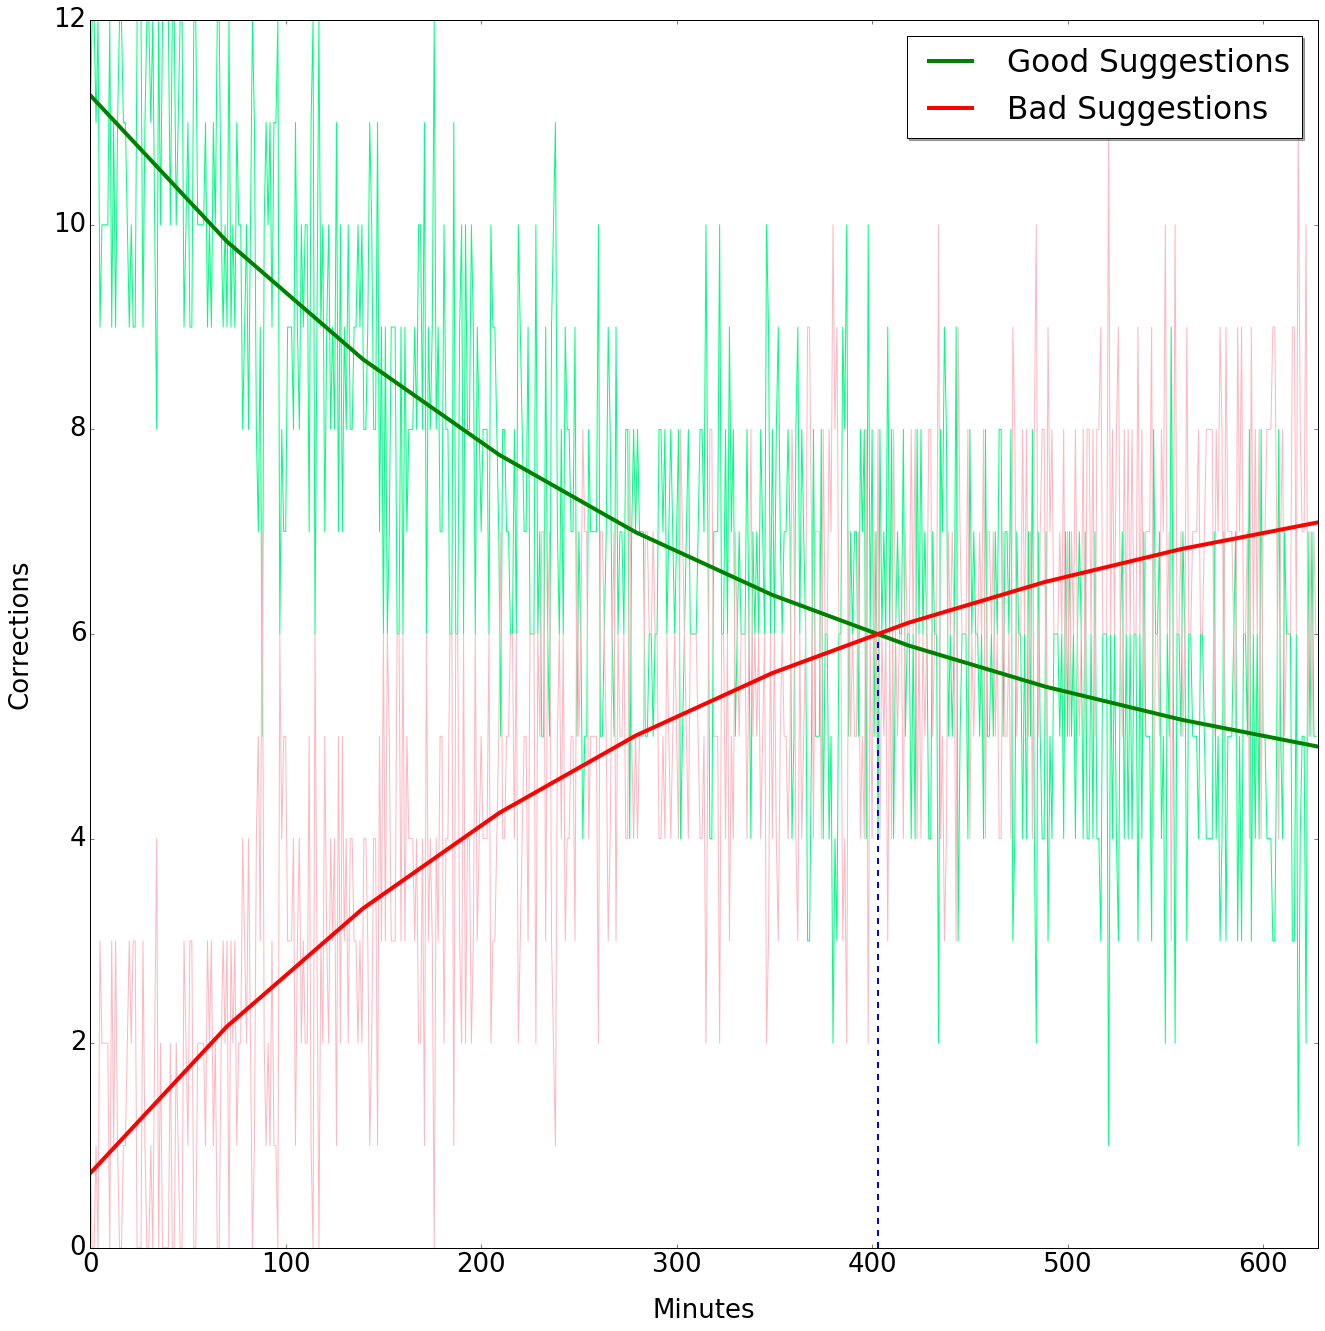

In [98]:
fig, ax = plt.subplots(figsize=(22,22))




x_marks = range(len(good_fixes_per_minute))

def green_func(x, a, b, c):
    return a*np.exp(-b*x)+c

def red_func(x, a, b, c):
    return 1-a*np.exp(-b*x)+c


popt, _ = curve_fit(green_func, x_marks, good_fixes_per_minute, p0=(1, 1e-6, 1))
goodx = np.linspace(0,len(good_fixes_per_minute),10)
goody = green_func(goodx, *popt)
popt2, _ = curve_fit(red_func, x_marks, bad_fixes_per_minute, p0=(1, 1e-6, 1))
bady = red_func(goodx, *popt2)


ax.plot(x_marks, good_fixes_per_minute, 'springgreen', linewidth=1)
ax.plot(x_marks, bad_fixes_per_minute ,'lightpink', linewidth=1)


ax.axvline(x=403, ymin=0, ymax=.5, color='b', linestyle='dashed', linewidth=2)
ax.plot(goodx, goody, 'g', linewidth=4, label='Good Suggestions')
ax.plot(goodx, bady, 'r', linewidth=4, label='Bad Suggestions')


# # fig, ax = plt.subplots()
# ax.plot(x_marks, old_vi_s, color='b', label='Automatic Corrections (Old CNN)')
# ax.plot(x_marks, new_vi_s, color='g', label='Automatic Corrections (New CNN)')
# ax.plot(x_marks, john_new_vi, color='r')
# ax.plot(x_marks, josh_new_vi, color='b')
plt.ylabel('Corrections', labelpad=20)

plt.xlabel('Minutes', labelpad=20)
plt.xlim([0,len(good_fixes_per_minute)])

# ax.plot(x_marks, alyssa_new_vi, color='r')
legend = ax.legend(loc='upper right', shadow=True)

# plt.plot()
plt.show()

In [18]:
from scipy.optimize import curve_fit

In [53]:
initial_vis = []
for z in range(len(volume)):
    vi = Util.vi(volume_groundtruth[z], volume_segmentation[z])
    initial_vis.append(vi)

In [59]:
proofread_vis = [initial_vis] + vi_s30mins

In [83]:
median_vis_30_mins = []
for i,vi in enumerate(proofread_vis):
    if i % 12 == 0:
        median_vis_30_mins.append(np.mean(vi))
median_vis_per_min = []
for m in median_vis_30_mins:
    for i in range(30):
        median_vis_per_min.append(m)

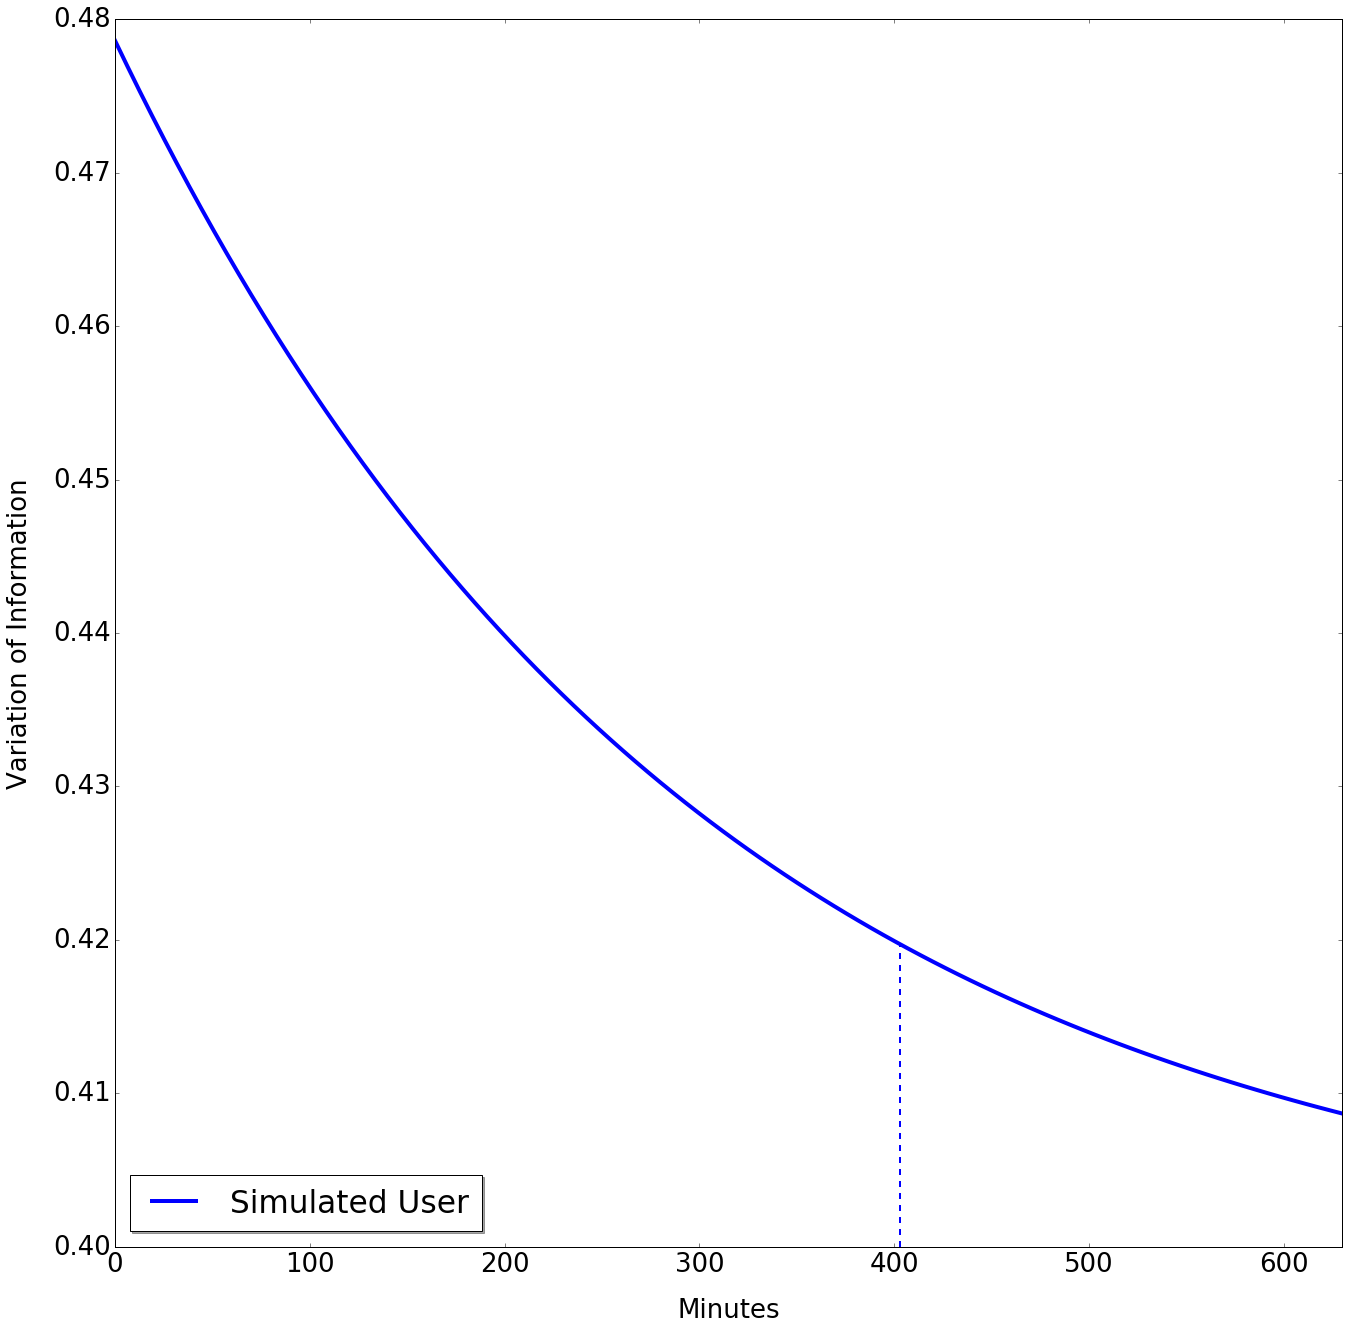

In [105]:
fig, ax = plt.subplots(figsize=(22,22))

x_marks = range(len(median_vis_per_min))

popt, _ = curve_fit(green_func, x_marks, median_vis_per_min)

xx = np.linspace(0,len(median_vis_per_min),100)
mediany = green_func(xx, *popt)

# ax.plot(x_marks, median_vis_per_min, 'r', label='Simulated User')

ax.plot(xx, mediany, linewidth=4, label='Simulated User')
ax.axvline(x=403, ymin=0, ymax=.245, color='b', linestyle='dashed', linewidth=2)

plt.ylabel('Variation of Information', labelpad=20)

plt.xlabel('Minutes', labelpad=20)
plt.xlim([0,len(median_vis_per_min)])
# plt.ylim([0.4,0.5])


legend = ax.legend(loc='lower left', shadow=True)

font = {'family' : 'normal',
        'size'   : 26}

plt.rc('font', **font)

plt.show()